Random Forest with time series:

Can’t use Random Forest to forecast into more than 1 value or indefinitely into the future as one can with linear model. What this means is that when I’m trying to predict 6 months into the future, I’ll need to actually use 6 months of past data as the input.

As an example, if my model is able to predict 6 months into the future; to predict the traffic at 1 July 2019 I will need to use the data points on for 1 Jan 2019 (for simplification, I assume all months have 30 days in a month). To predict for 2 July 2019, I’ll use 2 Jan 2019. And so on, until 30th June 2019, which gives me prediction for 30th Dec 2019.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier


In [2]:
# Load data
data = pd.read_csv("data/all_data.csv")
data.head()

,day,temperature_max,temperature_min,humidity,precip_intensity,precip_intensity_max,pressure,visibility,wind_speed,tomato_price,oil_price,lettuce_price,onion_price
0,2015-01-31 00:00:00+00:00,8.573571,2.237857,0.866429,22.079243,24.485486,1014.221429,4503.658571,5.548571,0.4975,47.759500,0.330,0.3125
1,2015-02-28 00:00:00+00:00,7.955000,1.872143,0.842143,0.050907,0.226479,1016.628571,5594.000000,4.152857,0.5680,58.095500,0.326,0.3400
2,2015-03-31 00:00:00+00:00,11.156250,3.781250,0.791875,0.011969,0.152994,1020.506250,4875.121250,4.885000,1.1420,55.885455,0.318,0.6760
3,2015-04-30 00:00:00+00:00,15.607333,4.617333,0.766000,0.003860,3.970053,1021.640000,5087.544000,4.008667,0.7825,59.524286,0.310,0.2300
4,2015-05-31 00:00:00+00:00,16.108750,8.606250,0.780625,0.053781,35.143356,1015.562500,6042.000000,4.691250,0.8625,64.075000,0.300,0.2350


In [3]:
# I check the shape
data.shape

(60, 13)

In [4]:
# round and reemplace missing values for mean
data = data.round(2)
data = data.fillna(value=round(data.mean(), 2))


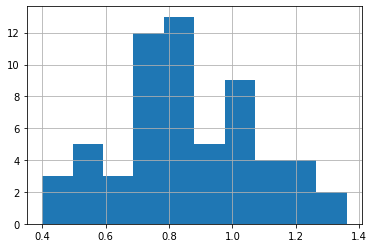

In [5]:
# Display histogram of the price scores
data['tomato_price'].hist()

In [6]:
# the histogram seem to be unbalanced


In [7]:
# I build a histogram to balance the tomato_price column

def transform(col):
    col = round(col, 2)
    if col < 0.89:
        return -1
    elif col > 0.89:
        return 1
    else: 
        return 0
data['tomato_price'] = data['tomato_price'].apply(transform)

data.tomato_price.value_counts()

-1    37
 1    23
Name: tomato_price, dtype: int64

Index(['day', 'temperature_max', 'temperature_min', 'humidity',
       'precip_intensity', 'precip_intensity_max', 'pressure', 'visibility',
       'wind_speed', 'tomato_price', 'oil_price', 'lettuce_price',
       'onion_price'],
      dtype='object')

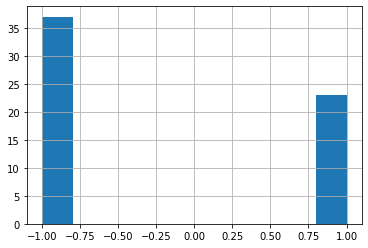

In [8]:
data['tomato_price'].hist()
data.columns

In [9]:
# I Scale/Normalize the numerical values

num_features = ['temperature_max', 'temperature_min', 'humidity',
       'precip_intensity', 'precip_intensity_max', 'pressure', 'visibility',
       'wind_speed', 'tomato_price', 'oil_price', 'lettuce_price',
       'onion_price']
numerical_transformer = Pipeline([
            ('payment_scaler', StandardScaler())
        ])
columns_transformer = ColumnTransformer([("numerical", numerical_transformer, num_features)])
columns_transformer.fit_transform(data)


array([[-1.33953745e+00, -1.44129886e+00,  1.11315291e+00,
         1.25421837e+00, -1.48350565e-01, -3.97528182e-01,
         2.80683455e-02, -2.94316100e-01, -7.88429846e-01,
        -8.24087048e-01, -5.79233881e-01, -3.17461134e-01],
       [-1.46545864e+00, -1.53080550e+00,  4.87004396e-01,
        -5.13337330e-01, -5.73394029e-01,  1.49456071e-01,
         7.96454192e-01, -6.36591504e-01, -7.88429846e-01,
         8.53433917e-02, -5.79233881e-01, -1.13378976e-01],
       [-8.13511827e-01, -1.06875770e+00, -5.56576453e-01,
        -5.16546691e-01, -5.74795657e-01,  1.03007802e+00,
         2.89844128e-01, -4.58119329e-01,  1.26834366e+00,
        -1.09031973e-01, -8.06384423e-01,  2.19955214e+00],
       [ 9.02773704e-02, -8.65553426e-01, -9.74008792e-01,
        -5.17349031e-01, -5.07867955e-01,  1.28654782e+00,
         4.39541031e-01, -6.70819044e-01, -7.88429846e-01,
         2.10236160e-01, -1.03353496e+00, -8.61680220e-01],
       [ 1.91826718e-01,  9.96668562e-02, -7.6529262

In [10]:
# I split the dataset into train and test.
y = data['tomato_price']
simplified_df = data.copy()
del simplified_df['tomato_price']
del simplified_df['day']
X = simplified_df.copy()
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=50)
X_train.shape
X_test.shape


(15, 11)

In [11]:
# Random Forest model
rf_model = RandomForestClassifier(class_weight="balanced", n_estimators=150, n_jobs=-1)

In [12]:
#Use grid search to find the best parameters for your rf_model
gs = GridSearchCV(rf_model, {"max_depth": [10, 15, 20],
                             "min_samples_split": [.005, .01, .05]}, 
                  n_jobs=-1, cv=5, scoring="balanced_accuracy")

gs.fit(X_train, y_train)

/Users/pola/miniconda3/envs/ads04/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=150, n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                  

In [13]:
print(gs.best_params_)

{'max_depth': 20, 'min_samples_split': 0.005}


In [14]:
# Random Forest model with the best parameters
rf_model = gs.best_estimator_
gs = GridSearchCV(rf_model, {"max_depth": [10],
                             "min_samples_split": [.05]}, 
                  n_jobs=-1, cv=5, scoring="balanced_accuracy")

gs.fit(X_train, y_train)

/Users/pola/miniconda3/envs/ads04/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=20,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=0.005,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=150, n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                

In [15]:
print(gs.best_score_)

0.6353703703703704


In [16]:
y_pred = rf_model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.6